In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score)
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical


JPEG Compression Results:
Original Size: 75.24 KB
Compressed Size: 24.01 KB
Compression Ratio: 3.13:1
MSE: 15.368336995442709
PSNR: 36.26453485741463 dB


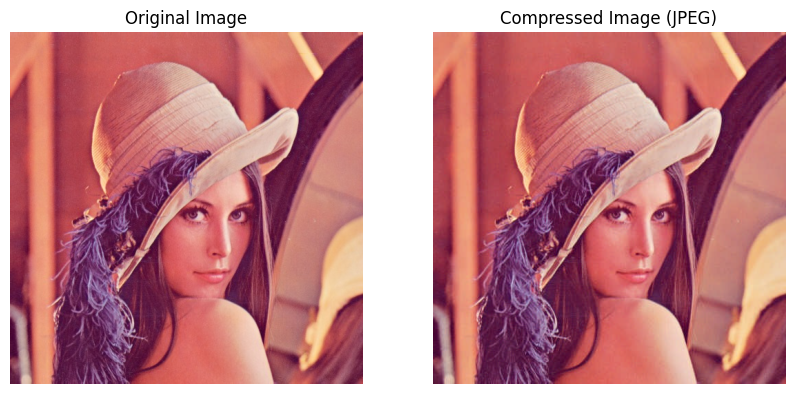

In [3]:
image = cv2.imread('/content/img1.jpeg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

height, width, channels = image.shape

# JPEG Standard Quantization Matrix for Luminance
quant_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
], dtype=np.float32)

# Function to perform DCT
def dct2(block):
    return cv2.dct(np.float32(block))

# Function to perform inverse DCT
def idct2(block):
    return cv2.idct(np.float32(block))

# JPEG Compression: Block-wise DCT and Quantization
block_size = 8
dct_blocks = np.zeros_like(image, dtype=np.float32)

for i in range(0, height - height % block_size, block_size):
    for j in range(0, width - width % block_size, block_size):
        for c in range(channels):
            block = image[i:i+block_size, j:j+block_size, c]
            dct_block = dct2(block)
            dct_blocks[i:i+block_size, j:j+block_size, c] = np.round(dct_block / quant_matrix) * quant_matrix

# Apply inverse DCT to reconstruct the image
idct_reconstructed = np.zeros_like(image, dtype=np.float32)

for i in range(0, height - height % block_size, block_size):
    for j in range(0, width - width % block_size, block_size):
        for c in range(channels):
            idct_reconstructed[i:i+block_size, j:j+block_size, c] = idct2(dct_blocks[i:i+block_size, j:j+block_size, c])

# Convert back to uint8 format
idct_reconstructed = np.clip(idct_reconstructed, 0, 255).astype(np.uint8)

# Ensure sizes match
idct_reconstructed = cv2.resize(idct_reconstructed, (width, height))

# Save the compressed image as JPEG
cv2.imwrite('compressed.jpg', cv2.cvtColor(idct_reconstructed, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, 50])

# Compute file sizes
original_size = os.path.getsize('/content/img1.jpeg') / 1024  # KB
compressed_size = os.path.getsize('compressed.jpg') / 1024  # KB
compression_ratio = original_size / compressed_size

# Define MSE and PSNR functions
def mse(imageA, imageB):
    return np.mean((imageA - imageB) ** 2)

def psnr(imageA, imageB):
    mse_value = mse(imageA, imageB)
    if mse_value == 0:
        return float('inf')
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse_value)

# Compute MSE and PSNR
mse_dct = mse(image, idct_reconstructed)
psnr_dct = psnr(image, idct_reconstructed)

# Print metrics
print("\nJPEG Compression Results:")
print(f"Original Size: {original_size:.2f} KB")
print(f"Compressed Size: {compressed_size:.2f} KB")
print(f"Compression Ratio: {compression_ratio:.2f}:1")
print(f"MSE: {mse_dct}")
print(f"PSNR: {psnr_dct} dB")

# Show original and reconstructed images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(idct_reconstructed)
plt.title("Compressed Image (JPEG)")
plt.axis('off')

plt.show()

In [ ]:
# def compress_image_jpeg(input_path, output_path, quality=20):
#     image = cv2.imread(input_path)
#     original_size = os.path.getsize(input_path) / 1024
#     cv2.imwrite(output_path, image, [cv2.IMWRITE_JPEG_QUALITY, quality])
#     compressed_size = os.path.getsize(output_path) / 1024
#     print(f"Original Size: {original_size:.2f} KB")
#     print(f"JPEG Compression Done: {compressed_size:.2f} KB")

# def compress_image_png(input_path, output_path, compression_level=9):
#     image = cv2.imread(input_path)
#     original_size = os.path.getsize(input_path) / 1024
#     cv2.imwrite(output_path, image, [cv2.IMWRITE_PNG_COMPRESSION, compression_level])
#     compressed_size = os.path.getsize(output_path) / 1024
#     print(f"Original Size: {original_size:.2f} KB")
#     print(f"PNG Compression Done: {compressed_size:.2f} KB")

# input_image = "/content/img1.jpeg"
# jpeg_output = "compressed_output.jpeg"
# png_output = "compressed_output.png"

# compress_image_jpeg(input_image, jpeg_output, quality=20)
# compress_image_png(input_image, png_output, compression_level=9)

Original Size: 75.24 KB
JPEG Compression Done: 13.48 KB
Original Size: 75.24 KB
PNG Compression Done: 398.81 KB


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
X = X.reshape(-1, 28, 28, 1).astype('float32') / 255.0
num_classes = 10
Y = to_categorical(y, num_classes)

In [ ]:
X_train, X_test, Y_train, Y_test, y_train_split, y_test_split = train_test_split(X, Y, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=20, verbose=1, validation_split=0.1)

Epoch 1/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8537 - loss: 0.4593 - val_accuracy: 0.9843 - val_loss: 0.0490
Epoch 2/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9744 - loss: 0.0871 - val_accuracy: 0.9895 - val_loss: 0.0355
Epoch 3/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9804 - loss: 0.0662 - val_accuracy: 0.9884 - val_loss: 0.0366
Epoch 4/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9848 - loss: 0.0503 - val_accuracy: 0.9914 - val_loss: 0.0320
Epoch 5/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9876 - loss: 0.0387 - val_accuracy: 0.9900 - val_loss: 0.0371
Epoch 6/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9880 - loss: 0.0388 - val_accuracy: 0.9896 - val_loss: 0.0368
Epoch 7/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9901 - loss: 0.0319 - val_accuracy: 0.9921 - val_loss: 0.0310
Epoch 8/20
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9909 - loss: 0.02

In [ ]:
pred_probs = model.predict(X_test)
predictions = np.argmax(pred_probs, axis=1)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
accuracy = accuracy_score(y_test_split, predictions)
precision = precision_score(y_test_split, predictions, average='macro')
recall = recall_score(y_test_split, predictions, average='macro')
f1 = f1_score(y_test_split, predictions, average='macro')
cm = confusion_matrix(y_test_split, predictions)
auc_score = roc_auc_score(Y_test, pred_probs, multi_class='ovr')

print("Accuracy: {:.4f}".format(accuracy))
print("Precision (Macro): {:.4f}".format(precision))
print("Recall (Macro): {:.4f}".format(recall))
print("F1-Measure (Macro): {:.4f}".format(f1))
print("AUC (OvR): {:.4f}".format(auc_score))
print("Confusion Matrix:\n", cm)

Accuracy: 0.9912
Precision (Macro): 0.9911
Recall (Macro): 0.9912
F1-Measure (Macro): 0.9911
AUC (OvR): 0.9999
Confusion Matrix:
 [[1338    0    0    0    0    0    2    1    2    0]
 [   0 1593    1    0    2    0    0    3    0    1]
 [   0    1 1373    1    0    0    1    1    3    0]
 [   0    0   10 1412    0    4    0    1    3    3]
 [   1    0    1    0 1287    0    0    0    1    5]
 [   0    0    1    5    0 1263    2    0    2    0]
 [   0    0    1    0    1    2 1391    0    1    0]
 [   0    3   10    0    3    0    0 1483    0    4]
 [   1    0    4    1    0    5    3    0 1338    5]
 [   3    0    0    0    9    4    0    1    4 1399]]


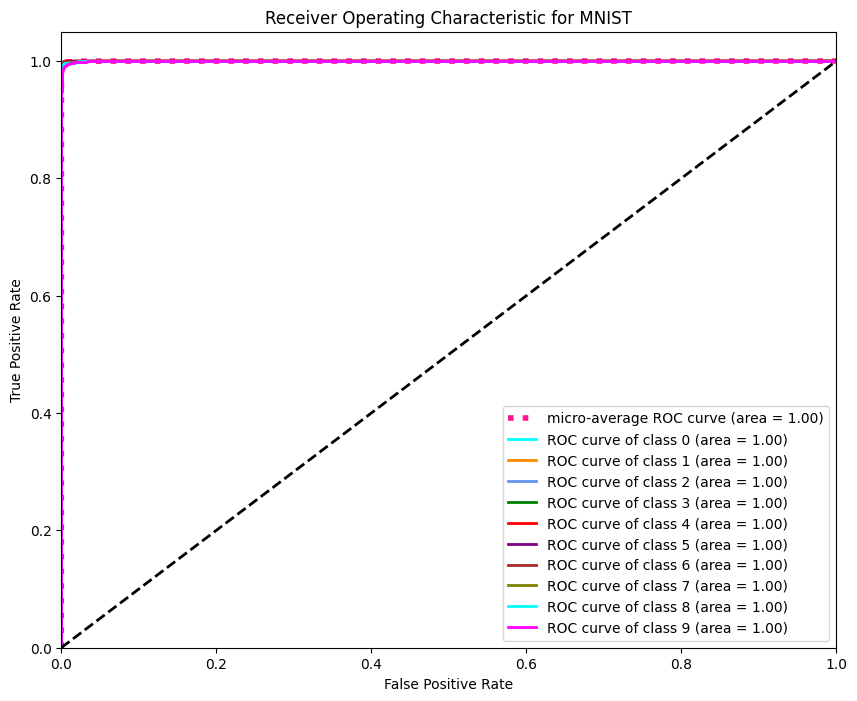

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'olive', 'cyan', 'magenta']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for MNIST')
plt.legend(loc="lower right")
plt.show()

In [ ]:
(x_train1, y_train1), (x_test1, y_test1) = cifar10.load_data()

X1 = np.concatenate((x_train1, x_test1), axis=0)
y1 = np.concatenate((y_train1, y_test1), axis=0)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
X2 = X1.astype('float32') / 255.0
num_classes = 10
y2 = to_categorical(y1, num_classes)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [ ]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,169,130 (8.27 MB)

 Trainable params: 2,168,746 (8.27 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history2= model2.fit(X_train2, y_train2,
                    batch_size=64,
                    epochs=50,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.3455 - loss: 2.1668 - val_accuracy: 0.5590 - val_loss: 1.2548
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5563 - loss: 1.2547 - val_accuracy: 0.5808 - val_loss: 1.1975
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6376 - loss: 1.0269 - val_accuracy: 0.6979 - val_loss: 0.8987
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6852 - loss: 0.9129 - val_accuracy: 0.7262 - val_loss: 0.8012
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7155 - loss: 0.8176 - val_accuracy: 0.7262 - val_loss: 0.8128
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7376 - loss: 0.7542 - val_accuracy: 0.7579 - val_loss: 0.6914
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7572 - loss: 0.6946 - val_accuracy: 0.7581 - val_loss: 0.7009
Epoch 8/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7747 - loss: 0.6393 - val_accuracy:

In [ ]:
pred_probs2 = model2.predict(X_test2)
true_labels2 = np.argmax(y_test2, axis=1)
predictions2 = np.argmax(pred_probs2, axis=1)

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
accuracy = accuracy_score(true_labels2, predictions2)
precision = precision_score(true_labels2, predictions2, average='macro')
recall = recall_score(true_labels2, predictions2, average='macro')
f1 = f1_score(true_labels2, predictions2, average='macro')
cm = confusion_matrix(true_labels2, predictions2)
auc_score = roc_auc_score(y_test2, pred_probs2, multi_class='ovr')

print("Test Accuracy: {:.4f}".format(accuracy))
print("Precision (macro): {:.4f}".format(precision))
print("Recall (macro): {:.4f}".format(recall))
print("F1-Measure (macro): {:.4f}".format(f1))
print("AUC (OvR): {:.4f}".format(auc_score))
print("Confusion Matrix:\n", cm)

Test Accuracy: 0.8237
Precision (macro): 0.8246
Recall (macro): 0.8258
F1-Measure (macro): 0.8242
AUC (OvR): 0.9816
Confusion Matrix:
 [[ 985   25   55   14    9    3    3    6   33   48]
 [   6 1086    3    5    1    6    6    0   10   65]
 [  41    5  986   38   44   24   67   15    5    7]
 [  27    4  100  814   39  161   74   18   13   24]
 [  16    0   58   36  921   31   50   54    8    5]
 [  10    3   72  154   33  876   24   48    2    8]
 [   2    2   36   28    7   26 1014    3    4    1]
 [   6    0   35   34   31   34    4 1053    6   14]
 [  54   32    5    3    4    3    6    5 1058   19]
 [   9   55    2    6    3    2    6    4    9 1091]]


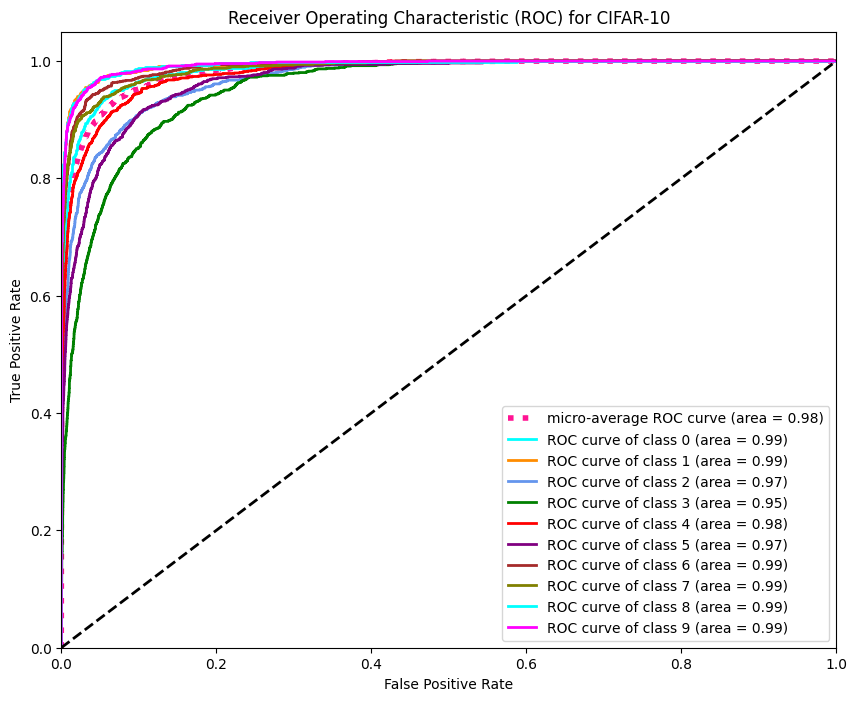

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], pred_probs2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test2.ravel(), pred_probs2.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
          'purple', 'brown', 'olive', 'cyan', 'magenta']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for CIFAR-10')
plt.legend(loc="lower right")
plt.show()